<a href="https://colab.research.google.com/github/yring-me/AI_Study/blob/main/pgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os.path

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 100530295.78it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119345511.16it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28763600.73it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19639720.38it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



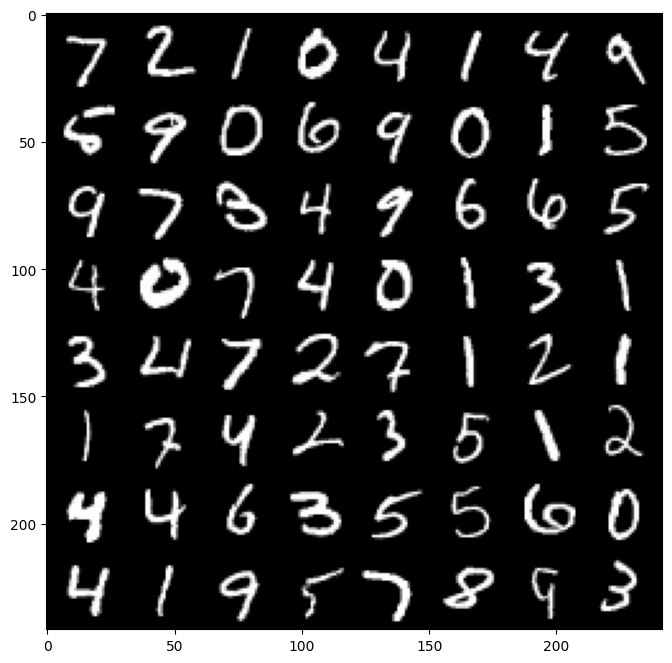

In [5]:
plt.figure(figsize=(8, 8))
iter_dataloader = iter(test_dataloader)

n=1

# 取出n*batch_size张图片可视化
for i in range(n):
    images, labels = next(iter_dataloader)
    image_grid = torchvision.utils.make_grid(images)
    plt.subplot(1, n, i+1)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,3,stride=1,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5,stride=1,padding=1),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(576,120),
            nn.Linear(120,84),
            nn.Linear(84,10)
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

Epoch 1 loss: 0.022908
Epoch 2 loss: 0.005100
Epoch 3 loss: 0.003627
Epoch 4 loss: 0.002702
Epoch 5 loss: 0.002148
Epoch 6 loss: 0.001812
Epoch 7 loss: 0.001591
Epoch 8 loss: 0.001433
Epoch 9 loss: 0.001312
Epoch 10 loss: 0.001215


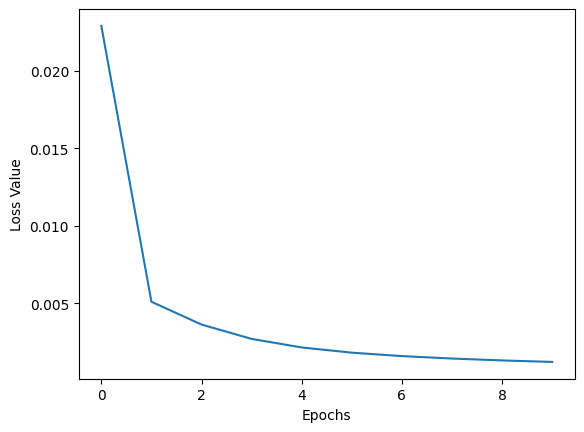

In [8]:
def train(network):

    losses = []
    iteration = 0

    epochs = 10

    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = loss_sum / len(train_dataloader.dataset)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")

    # 绘制损失函数曲线
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.plot(list(range(iteration)), losses)
network = LeNet()
network.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)

if os.path.exists('model.pth'):
    network.load_state_dict(torch.load('model.pth'))
else:
    train(network)

In [9]:
positive = 0
negative = 0
for X, y in test_dataloader:
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        pred = network(X)
        for item in zip(pred, y):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1
acc = positive / (positive + negative)
print(f"{acc * 100}%")

97.72999999999999%


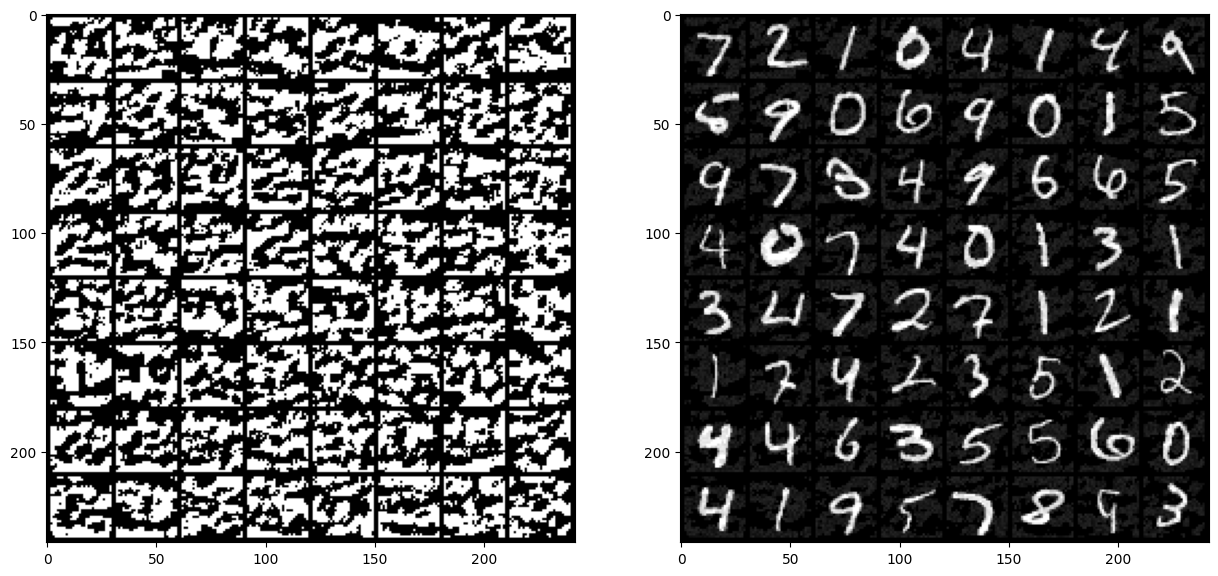

In [12]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)

    random_noise = torch.tensor(np.random.uniform(-0.05,0.05,X.shape)).cuda()
    X += random_noise
    # exit(1)
    X.requires_grad = True
    pred = network(X)

    network.zero_grad()
    loss = loss_fn(pred, y)
    loss.backward()

    plt.figure(figsize=(15, 8))

    plt.subplot(121)
    image_grid = torchvision.utils.make_grid(torch.clamp(X.grad.sign(), 0, 1))
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))

    X_adv = X + eps[2] * X.grad.sign()
    X_adv = torch.clamp(X_adv, 0, 1)

    plt.subplot(122)
    image_grid = torchvision.utils.make_grid(X_adv)
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))

    break

epsilon=0.01 acc: 96.65%
epsilon=0.05 acc: 91.545%
epsilon=0.1 acc: 80.14333333333333%
epsilon=0.2 acc: 61.3275%
epsilon=0.3 acc: 49.138%
epsilon=0.4 acc: 40.961666666666666%
epsilon=0.5 acc: 35.11714285714286%
epsilon=0.6 acc: 30.73625%
epsilon=0.7 acc: 27.358888888888888%
epsilon=0.8 acc: 24.694%


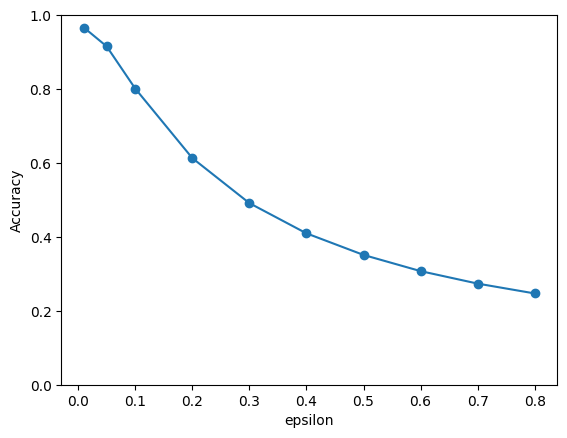

In [13]:
positive = 0
negative = 0
acc_list = []
for epsilon in eps:

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        random_noise = torch.tensor(np.random.uniform(-0.05,0.05,X.shape)).cuda()
        X += random_noise
        X.requires_grad = True
        pred = network(X)
        network.zero_grad()
        loss = loss_fn(pred, y)
        loss.backward()

        X = X + epsilon * X.grad.sign()
        X_adv = torch.clamp(X, 0, 1)

        pred = network(X_adv)
        for item in zip(pred, y):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1

    acc = positive / (positive + negative)
    print(f"epsilon={epsilon} acc: {acc * 100}%")
    acc_list.append(acc)

plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.plot(eps, acc_list, marker='o')